In [3]:
# make sure kaggle 1.5.12 is installed and api key is configured (~/.kaggle/kaggle.json), if not then:
# !pip install --upgrade --force-reinstall --no-deps kaggle

# later:
# !kaggle competitions download -c petfinder-pawpularity-score
# !unzip -q petfinder-pawpularity-score.zip -d input

100%|████████████████████████████████████████| 983M/983M [02:56<00:00, 11.6MB/s]
100%|████████████████████████████████████████| 983M/983M [02:56<00:00, 5.84MB/s]


In [2]:
import pandas as pd

data_dir = "input" #if using the code above
#data_dir = "~/Downloads/petfinder-pawpularity-score" #comment it out if using the code above

df = pd.read_csv(f"{data_dir}/train.csv")
df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


Text(0.5, 1.0, 'Distribution of pet popularity')

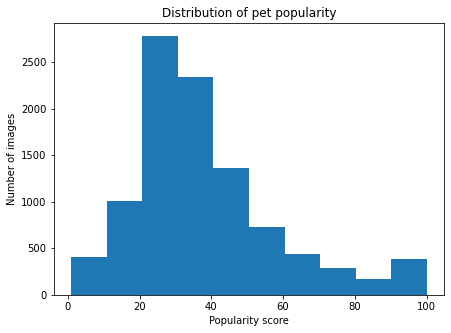

In [59]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7,5)
plt.hist(df['Pawpularity'])
plt.xlabel('Popularity score')
plt.ylabel('Number of images')
plt.title('Distribution of pet popularity')

# Baseline

In [100]:
from sklearn import linear_model, ensemble, svm, neighbors, gaussian_process, cross_decomposition, tree, neural_network, model_selection, metrics
import random
import numpy as np

import warnings
warnings.filterwarnings('ignore')


def run_baseline_models(df):

    X = df.drop(["Pawpularity","Id"], axis=1)
    y = df["Pawpularity"]


    models = [
        linear_model.LinearRegression,
        linear_model.BayesianRidge,
        linear_model.ElasticNet,
        linear_model.SGDRegressor,
        ensemble.RandomForestRegressor,
        ensemble.AdaBoostRegressor,
        ensemble.GradientBoostingRegressor,
        ensemble.BaggingRegressor,
        svm.SVR,
        neighbors.KNeighborsRegressor,
        neighbors.RadiusNeighborsRegressor,
        cross_decomposition.PLSRegression,
        tree.DecisionTreeRegressor,
        neural_network.MLPRegressor
    ]

    losses = dict()

    for model_cls in models:
        model = model_cls()
        scores = model_selection.cross_val_score(model, X, y, scoring="neg_root_mean_squared_error") * -1
        print(f"{model_cls.__name__}: {scores.round(4)}")
        losses[model_cls.__name__] = scores


    # totally random baseline:
    def random_rmse(y):
        _, y_test = model_selection.train_test_split(y)
        return metrics.mean_squared_error(y_test, [random.randint(1, 100) for i in range(len(y_test))], squared=False)

    losses["random"] = [random_rmse(y) for i in range(5)]

    result =  pd.DataFrame.from_dict(data=losses, orient="index")
    result["mean"] = result.apply(lambda row: row.mean(), axis=1)
    result["min"] = result.apply(lambda row: row.min(), axis=1)
    result["max"] = result.apply(lambda row: row.max(), axis=1)

    return result.sort_values(by="mean", ascending=True)


In [105]:
import matplotlib.pyplot as plt
import numpy as np

def draw_results(result):
    groups = np.arange(0, len(result.index))* (-4)

    plt.figure(figsize=(8,8))
    plt.barh(groups+1, result["min"], color="green", label="min")
    plt.barh(groups, result["mean"], color="blue", label="mean")
    plt.barh(groups-1, result["max"], color="red", label="max")

    plt.yticks(groups, result.index)
    plt.legend()
    plt.show()



## Baseline without feature engineering

In [101]:
result = run_baseline_models(df)

LinearRegression: [20.7124 20.8424 20.8812 20.1258 20.426 ]
BayesianRidge: [20.7034 20.8227 20.915  20.1187 20.4009]
ElasticNet: [20.702  20.8087 20.915  20.1187 20.4009]
SGDRegressor: [20.7129 20.8385 20.8924 20.1337 20.4307]
RandomForestRegressor: [20.8905 20.9743 21.012  20.3289 20.6254]
AdaBoostRegressor: [21.1332 21.1557 21.1178 20.5959 20.7762]
GradientBoostingRegressor: [20.7273 20.8792 20.8871 20.1601 20.4318]
BaggingRegressor: [20.9145 20.9796 21.029  20.3739 20.6547]
SVR: [21.2024 21.3595 21.4271 20.71   20.9424]
KNeighborsRegressor: [23.5003 23.7901 22.7031 22.298  22.6859]
RadiusNeighborsRegressor: [20.7063 20.7912 20.9256 20.1516 20.3703]
PLSRegression: [20.7139 20.8286 20.8995 20.1233 20.4233]
DecisionTreeRegressor: [20.9265 21.0616 21.0833 20.4299 20.7987]
MLPRegressor: [20.7129 20.8263 20.8714 20.1508 20.397 ]


In [102]:
result.round(4)

,0,1,2,3,4,mean,min,max
RadiusNeighborsRegressor,20.7063,20.7912,20.9256,20.1516,20.3703,20.5890,20.1516,20.9256
ElasticNet,20.7020,20.8087,20.9150,20.1187,20.4009,20.5890,20.1187,20.9150
MLPRegressor,20.7129,20.8263,20.8714,20.1508,20.3970,20.5917,20.1508,20.8714
BayesianRidge,20.7034,20.8227,20.9150,20.1187,20.4009,20.5921,20.1187,20.9150
LinearRegression,20.7124,20.8424,20.8812,20.1258,20.4260,20.5976,20.1258,20.8812
PLSRegression,20.7139,20.8286,20.8995,20.1233,20.4233,20.5977,20.1233,20.8995
SGDRegressor,20.7129,20.8385,20.8924,20.1337,20.4307,20.6016,20.1337,20.8924
GradientBoostingRegressor,20.7273,20.8792,20.8871,20.1601,20.4318,20.6171,20.1601,20.8871
RandomForestRegressor,20.8905,20.9743,21.0120,20.3289,20.6254,20.7662,20.3289,21.0120
BaggingRegressor,20.9145,20.9796,21.0290,20.3739,20.6547,20.7903,20.3739,21.0290


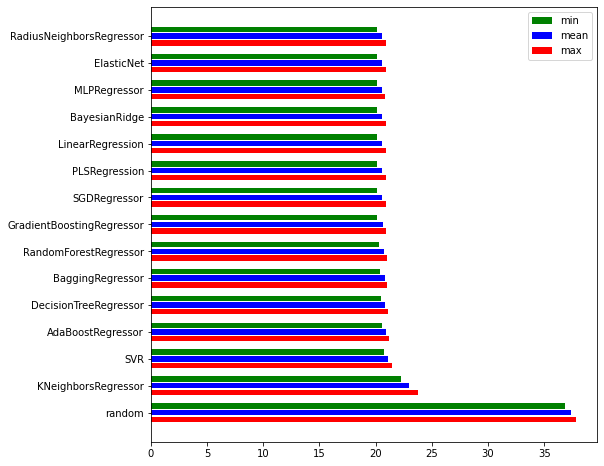

In [106]:
draw_results(result)

## Baseline with added features

In [84]:
df2 = pd.read_csv(f"{data_dir}/train2.csv")

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,lime,dark_green,cyan,teal,blue,violet,purple,dark_red,red,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,0.0,0.000090,0.000000,0.000603,0.000000,0.000028,0.0,0.001269,0.000007,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.000033,0.000000,0.001019,0.0,0.010453,0.000000,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,0.0,0.059440,0.004287,0.413299,0.082291,0.008185,0.0,0.000190,0.000000,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,0.0,0.000000,0.000000,0.000006,0.000000,0.000135,0.0,0.000247,0.000000,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,0.0,0.000033,0.000000,0.001532,0.000000,0.000938,0.0,0.000451,0.000003,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,0.0,0.000316,0.000000,0.000288,0.000000,0.000003,0.0,0.000218,0.000000,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000027,0.0,0.000588,0.000712,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.002439,0.001207,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,0.0,0.000075,0.000000,0.000081,0.000000,0.000111,0.0,0.048433,0.121717,20


In [267]:
# normalise column values to 0...1
columns_to_normalise = ["hue", 'saturation', 'brightness', 'contrast', 'contrast2', 'blur', 'warmth',
                        'aspect_ratio', 'dpi', 'white', 'light_grey', 'grey', 'black', 'brown',
                        'orange', 'green', 'lime', 'dark_green', 'cyan', 'teal', 'blue',
                        'violet', 'purple', 'dark_red', 'red']

for col in columns_to_normalise:
    df2[col] = df2[col] / df2[col].max()

df2

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,lime,dark_green,cyan,teal,blue,violet,purple,dark_red,red,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,1.0000,0.9997,1.0000,0.9987,1.0000,0.9999,1.0000,0.9970,1.0000,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,1.0000,1.0000,1.0000,0.9999,1.0000,0.9977,1.0000,0.9755,1.0000,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,1.0000,0.8289,0.9859,0.0770,0.8278,0.9815,1.0000,0.9996,1.0000,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,1.0000,1.0000,1.0000,1.0000,1.0000,0.9997,1.0000,0.9994,1.0000,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,1.0000,0.9999,1.0000,0.9966,1.0000,0.9979,1.0000,0.9989,1.0000,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,1.0000,0.9991,1.0000,0.9994,1.0000,1.0000,1.0000,0.9995,1.0000,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,1.0000,1.0000,1.0000,1.0000,1.0000,0.9999,1.0000,0.9986,0.9983,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9943,0.9971,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,1.0000,0.9998,1.0000,0.9998,1.0000,0.9997,1.0000,0.8867,0.7049,20


In [268]:
result2 = run_baseline_models(df2)

LinearRegression: [20.7327 20.8106 20.8347 20.0875 20.4   ]
BayesianRidge: [20.7016 20.7742 20.8502 20.0888 20.3637]
ElasticNet: [20.702  20.8087 20.915  20.1187 20.4009]
SGDRegressor: [20.7224 20.8277 20.8193 20.109  20.4206]
RandomForestRegressor: [20.8971 21.0025 21.2352 20.4215 20.5702]
AdaBoostRegressor: [21.8529 21.7227 22.3451 21.5036 20.5817]
GradientBoostingRegressor: [20.6984 20.8258 20.9049 20.1752 20.4595]
BaggingRegressor: [21.9534 21.852  22.4645 21.2272 21.703 ]
SVR: [21.1936 21.3781 21.4161 20.6599 20.8868]
KNeighborsRegressor: [22.6879 22.2861 22.4341 22.0994 21.955 ]
RadiusNeighborsRegressor: [2.87744495e+18 2.86249709e+18 2.94451375e+18 2.92256676e+18
 2.81026201e+18]
PLSRegression: [20.7489 20.8289 20.8888 20.1141 20.3859]
DecisionTreeRegressor: [30.1056 30.1318 29.4093 29.2923 30.1491]
MLPRegressor: [20.7898 20.8425 20.8833 20.1177 20.3726]


In [122]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
result2.round(4)

,0,1,2,3,4,mean,min,max
BayesianRidge,20.7011,20.7750,20.8509,20.0861,20.3638,20.5554,20.0861,20.8509
ElasticNet,20.7020,20.8087,20.9150,20.1187,20.4009,20.5890,20.1187,20.9150
SGDRegressor,20.7248,20.7981,20.8835,20.1501,20.3993,20.5912,20.1501,20.8835
PLSRegression,20.7489,20.8289,20.8888,20.1141,20.3859,20.5933,20.1141,20.8888
GradientBoostingRegressor,20.6971,20.8237,20.8904,20.1834,20.4530,20.6095,20.1834,20.8904
MLPRegressor,20.8484,20.7978,20.8648,20.1306,20.4224,20.6128,20.1306,20.8648
LinearRegression,20.7327,20.8109,21.1736,20.0875,20.4000,20.6410,20.0875,21.1736
RandomForestRegressor,21.0119,20.9593,21.2177,20.4412,20.6458,20.8552,20.4412,21.2177
SVR,21.1872,21.3781,21.4192,20.6574,20.8835,21.1051,20.6574,21.4192
AdaBoostRegressor,21.6736,21.7454,21.5968,21.6436,21.7702,21.6859,21.5968,21.7702


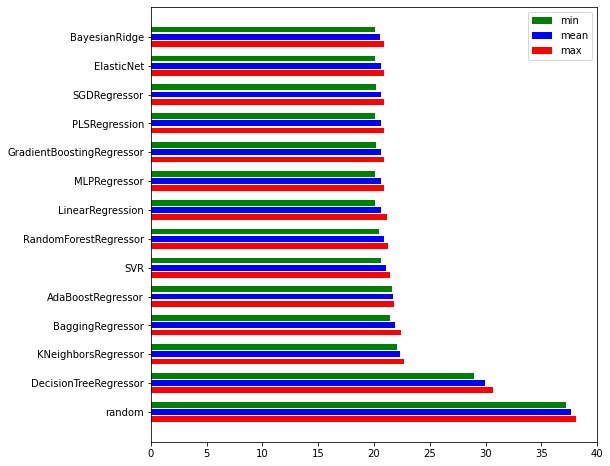

In [124]:
draw_results(result2.drop(["RadiusNeighborsRegressor"]))

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval, Trials
import math

In [282]:
def drop_features_by_index(X, drops):
    # remove duplicates
    drops = list(dict.fromkeys(drops))

    # go from right to left
    drops.sort(reverse=True)
    for f in drops:
        X = X.drop(X.columns[f], axis=1)

    return X


def get_feature_indices(args):
    indices = [v for k,v in args.items() if k.startswith("drop_feature_")]
    #remove duplicates
    return list(dict.fromkeys(indices))

def objective(args):

    global df2

    X = df2.drop(["Pawpularity","Id"], axis=1)
    y = df2["Pawpularity"]

    # calc features to drop
    drops = get_feature_indices(args)
    X = drop_features_by_index(X, drops)

    model_def = args["model"]

    if args["model"]["type"] == "BayesianRidge":
        model = linear_model.BayesianRidge(
            n_iter = model_def["n_iter"],
            alpha_1 = model_def["alpha_1"],
            alpha_2 = model_def["alpha_2"],
            lambda_1 = model_def["lambda_1"],
            lambda_2 = model_def["lambda_1"],
        )

    if args["model"]["type"] == "ElasticNet":
        model = linear_model.ElasticNet(
            alpha=model_def["alpha"],
            l1_ratio=model_def["l1_ratio"]
        )

    if args["model"]["type"] == "SGDRegressor":
        model = linear_model.SGDRegressor(
            alpha=model_def["alpha"],
            l1_ratio=model_def["l1_ratio"]
        )

    if args["model"]["type"] == "MLPRegressor":
        model = neural_network.MLPRegressor(
            hidden_layer_sizes=(model_def["hidden_layer_sizes"],),
            alpha=model_def["alpha"],
            solver=model_def["solver"]
        )

    scores = model_selection.cross_val_score(model, X, y, scoring="neg_root_mean_squared_error") * -1
    return np.mean(scores)

In [232]:
space = {
    "model": hp.choice("model", [
        {
            "type": "BayesianRidge",
            "n_iter": hp.uniformint("bayes_n_iter", 200, 500),
            "alpha_1": hp.uniform("bayes_alpha_1", 1e-8, 1e-4),
            "alpha_2": hp.uniform("bayes_alpha_2", 1e-8, 1e-4),
            "lambda_1": hp.uniform("bayes_lambda_1", 1e-8, 1e-4),
            "lambda_2": hp.uniform("bayes_lambda_2", 1e-8, 1e-4),
        },
        {
            "type": "ElasticNet",
            "alpha": hp.uniform("elastic_alpha", 0.5, 2),
            "l1_ratio": hp.uniform("elastic_l1", 0, 1)
        },
        {
            "type": "SGDRegressor",
            "alpha": hp.uniform("sgd_alpha", 0.00001, 0.001),
            "l1_ratio": hp.uniform("sgd_l1", 0, 1)
        },
        # {
        #     "type": "MLPRegressor",
        #     "hidden_layer_sizes": hp.choice("mlp_layers_size", [100, 200, 300]),
        #     'alpha':hp.lognormal('mlp_alpha', mu=np.log(1e-4), sigma=1),
        #     'solver':hp.choice('mlp_solver', ['lbfgs', 'sgd', 'adam'])
        # }
    ]),
    "drop_feature_0": hp.uniformint("drop_feature_0", 0, X.shape[1]-1),
    "drop_feature_1": hp.uniformint("drop_feature_1", 0, X.shape[1]-1),
    "drop_feature_2": hp.uniformint("drop_feature_2", 0, X.shape[1]-1),
}

best = fmin(objective, space, algo = tpe.suggest, max_evals=10000)
#hyperopt.pyll.stochastic.sample(space)

(space_eval(space, best))


100%|██████████| 10000/10000 [1:58:26<00:00,  1.41trial/s, best loss: 20.54404889010004]


{'drop_feature_0': 3,
 'drop_feature_1': 7,
 'drop_feature_2': 19,
 'model': {'alpha_1': 5.0042757161530806e-05,
  'alpha_2': 2.2305134933294197e-05,
  'lambda_1': 5.8501650382826934e-05,
  'lambda_2': 5.954285663965207e-05,
  'n_iter': 319,
  'type': 'BayesianRidge'}}

In [233]:
space2 = {
    "model": hp.choice("model", [
        {
            "type": "BayesianRidge",
            "n_iter": hp.uniformint("bayes_n_iter", 200, 500),
            "alpha_1": hp.uniform("bayes_alpha_1", 1e-8, 1e-4),
            "alpha_2": hp.uniform("bayes_alpha_2", 1e-8, 1e-4),
            "lambda_1": hp.uniform("bayes_lambda_1", 1e-8, 1e-4),
            "lambda_2": hp.uniform("bayes_lambda_2", 1e-8, 1e-4),
        },
        {
            "type": "ElasticNet",
            "alpha": hp.uniform("elastic_alpha", 0.5, 2),
            "l1_ratio": hp.uniform("elastic_l1", 0, 1)
        },
        {
            "type": "SGDRegressor",
            "alpha": hp.uniform("sgd_alpha", 0.00001, 0.001),
            "l1_ratio": hp.uniform("sgd_l1", 0, 1)
        },
        {
            "type": "MLPRegressor",
            "hidden_layer_sizes": hp.choice("mlp_layers_size", [100, 200, 300]),
            'alpha':hp.lognormal('mlp_alpha', mu=np.log(1e-4), sigma=1),
            'solver':hp.choice('mlp_solver', ['lbfgs', 'sgd', 'adam'])
        }
    ]),
    "drop_feature_0": hp.uniformint("drop_feature_0", 0, X.shape[1]-1),
    "drop_feature_1": hp.uniformint("drop_feature_1", 0, X.shape[1]-1),
    "drop_feature_2": hp.uniformint("drop_feature_2", 0, X.shape[1]-1),
}

best2 = fmin(objective, space2, algo = tpe.suggest, max_evals=10000)
#hyperopt.pyll.stochastic.sample(space)

(space_eval(space2, best2))

100%|██████████| 10000/10000 [5:07:27<00:00,  1.84s/trial, best loss: 20.544048831904863]  


{'drop_feature_0': 3,
 'drop_feature_1': 19,
 'drop_feature_2': 7,
 'model': {'alpha_1': 9.975485827537099e-05,
  'alpha_2': 4.280861256930258e-05,
  'lambda_1': 1.0962300332032549e-07,
  'lambda_2': 1.0676469280073962e-05,
  'n_iter': 282,
  'type': 'BayesianRidge'}}

In [240]:
from hpsklearn import HyperoptEstimator, svc
from sklearn import svm

In [260]:
space3 = {
    "model": hp.choice("model", [
        {
            "type": "BayesianRidge",
            "n_iter": hp.uniformint("bayes_n_iter", 100, 900),
            "alpha_1": hp.uniform("bayes_alpha_1", 1e-10, 1e-1),
            "alpha_2": hp.uniform("bayes_alpha_2", 1e-10, 1e-1),
            "lambda_1": hp.uniform("bayes_lambda_1", 1e-10, 1e-1),
            "lambda_2": hp.uniform("bayes_lambda_2", 1e-10, 1e-1),
        },
        {
            "type": "ElasticNet",
            "alpha": hp.uniform("elastic_alpha", 0.1, 4),
            "l1_ratio": hp.uniform("elastic_l1", 0, 1)
        },
        {
            "type": "SGDRegressor",
            "alpha": hp.uniform("sgd_alpha", 0.000001, 0.1),
            "l1_ratio": hp.uniform("sgd_l1", 0, 1)
        },
        {
            "type": "MLPRegressor",
            "hidden_layer_sizes": hp.choice("mlp_layers_size", [100, 200, 300, 500]),
            'alpha':hp.uniform('mlp_alpha', 0.000001, 0.1),
            'solver':hp.choice('mlp_solver', ['lbfgs', 'sgd', 'adam'])
        }
    ]),
    "drop_feature_0": hp.uniformint("drop_feature_0", 0, X.shape[1]-1),
    "drop_feature_1": hp.uniformint("drop_feature_1", 0, X.shape[1]-1),
    "drop_feature_2": hp.uniformint("drop_feature_2", 0, X.shape[1]-1),
    "drop_feature_3": hp.uniformint("drop_feature_3", 0, X.shape[1]-1),
    "drop_feature_4": hp.uniformint("drop_feature_4", 0, X.shape[1]-1),
    "drop_feature_5": hp.uniformint("drop_feature_5", 0, X.shape[1]-1),
}

best3 = fmin(objective, space3, algo = tpe.suggest, max_evals=1000)


(space_eval(space3, best3))

100%|██████████| 1000/1000 [03:14<00:00,  5.15trial/s, best loss: 20.543172298345088]


{'drop_feature_0': 34,
 'drop_feature_1': 12,
 'drop_feature_2': 19,
 'drop_feature_3': 9,
 'drop_feature_4': 7,
 'drop_feature_5': 9,
 'model': {'alpha_1': 0.07113899442241944,
  'alpha_2': 0.027808833733416437,
  'lambda_1': 4.3632812506737284e-05,
  'lambda_2': 0.08582921220593691,
  'n_iter': 774,
  'type': 'BayesianRidge'}}

In [266]:
from scipy.stats import ttest_ind, ttest_ind_from_stats


X = df2.drop(["Pawpularity","Id"], axis=1)
X = drop_features_by_index(X, [3,9,7,19,10,5])
y = df2["Pawpularity"]


scores_baseline = model_selection.cross_val_score(linear_model.BayesianRidge(), X, y, scoring="neg_root_mean_squared_error") * -1
scores_best_model = model_selection.cross_val_score(linear_model.BayesianRidge(
    alpha_1=0.06748333082329638,
    alpha_2=0.07190365480503146,
    lambda_1=4.960510739533382e-05,
    lambda_2=0.05681786469111417,
    n_iter=827,
), X, y, scoring="neg_root_mean_squared_error") * -1


t,p = ttest_ind(
    a = scores_baseline,
    b = scores_best_model
)

np.round(p, 4)

0.9998